In [21]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

In [2]:
# load simulated rainbow:
# r = Rainbow("test/b_withtransit_dw01.rainbow.npy")
# load Eureka! rainbow:
r_eureka = Rainbow("test/ERS_eureka/S3_nircam_wfss_template_ap8_bg16_Table_Save.txt")
# load jwst rainbow:
r_jwst = Rainbow("test/ERS_jwst/*x1dints.fits")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


In [ ]:
binwave = 0.1
bintime = 5./60
r = r_eureka.bin(dw=binwave * u.micron, dt=bintime * u.hour)

# Create Synthetic Rainbow with Transit + Polynomial

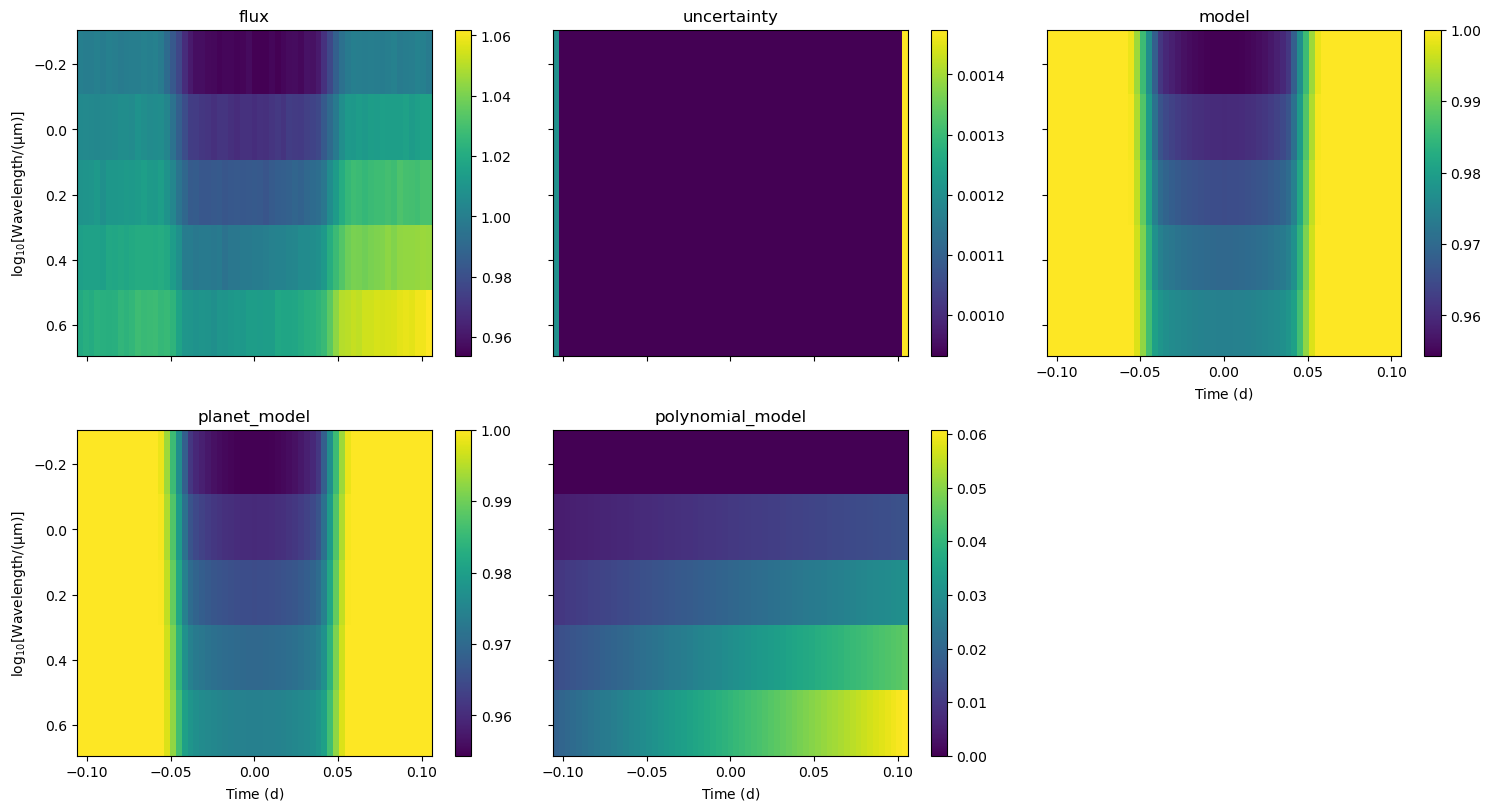

In [23]:
# create polynomial + transit rainbow:

r1 = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)
r1 = r1.bin(nwavelengths=int(r1.nwave/5), dt=5 * u.minute)
poly=[]

# create wavelength-dep linear model:
for i in range(r1.nwave):
#     (0.5*i*(r1.time.to_value())**2) +
    poly.append((0.05*i*r1.time.to_value()) + (0.01*i))
r1.flux = r1.flux + poly

# add transit:
r = r1.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r1.nwave))
    
r.fluxlike['polynomial_model'] = np.array(poly)
r.imshow_quantities();

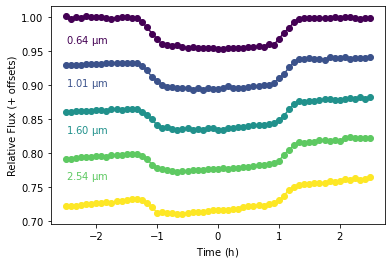

In [3]:
# plot 2d Lightcurves:
r.plot()

## White light curve


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

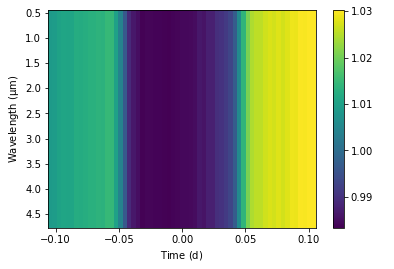

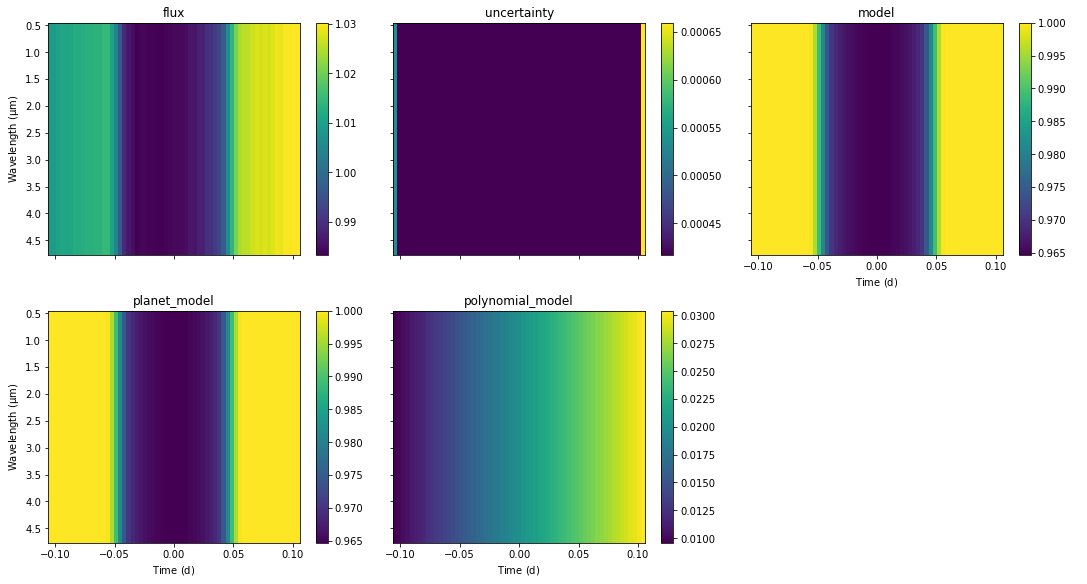

In [4]:
wa = r.bin(nwavelengths=r.nwave)
wa.imshow()
wa.imshow_quantities()

# Polynomial Model

In [24]:
# set up polynomial model:
b = PolynomialModel()
b.initialize_empty_model()
b.setup_parameters(p=WavelikeFitted(Uniform,testval=[0,0.1],upper=[0.1,0.2],lower=[-0.1,-0.2],shape=2))
b.summarize_parameters()
b.attach_data(r)
# if I setup_lightcurves for b before t it doesn't work!
b.setup_lightcurves()
# b.setup_likelihood()

p =
  <🧮 WavelikeFitted Uniform(testval=[0, 0.1], upper=[0.1, 0.2], lower=[-0.1, -0.2], shape=2, name='p') for each wavelength 🧮>



# Transit Model

In [25]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
#                     baseline=b
                )

t.summarize_parameters()

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



In [32]:
t.attach_data(r)
t.choose_optimization_method("separate")
t.optimization

'separate'

In [33]:
t.setup_lightcurves()
t.setup_likelihood()

0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]


2


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 53544.31it/s]


3


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 73908.44it/s]


4


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]


In [34]:
t.summarize_parameters()

stellar_radius =
  <🧮 WavelikeFitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') for each wavelength 🧮>

stellar_mass =
  <🧮 WavelikeFitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') for each wavelength 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 WavelikeFixed | one value for each wavelength (5 elements)🧮>

epoch =
  <🧮 WavelikeFitted Uniform(lower=-0.05, upper=0.05, name='epoch') for each wavelength 🧮>

baseline =
  <🧮 WavelikeFitted Uniform(lower=0.95, upper=1.05, name='baseline') for each wavelength 🧮>

impact_parameter =
  <🧮 WavelikeFitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') for each wavelength 🧮>

limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') for each wavelength 🧮>




🌈 Warning: invalid value encountered in log

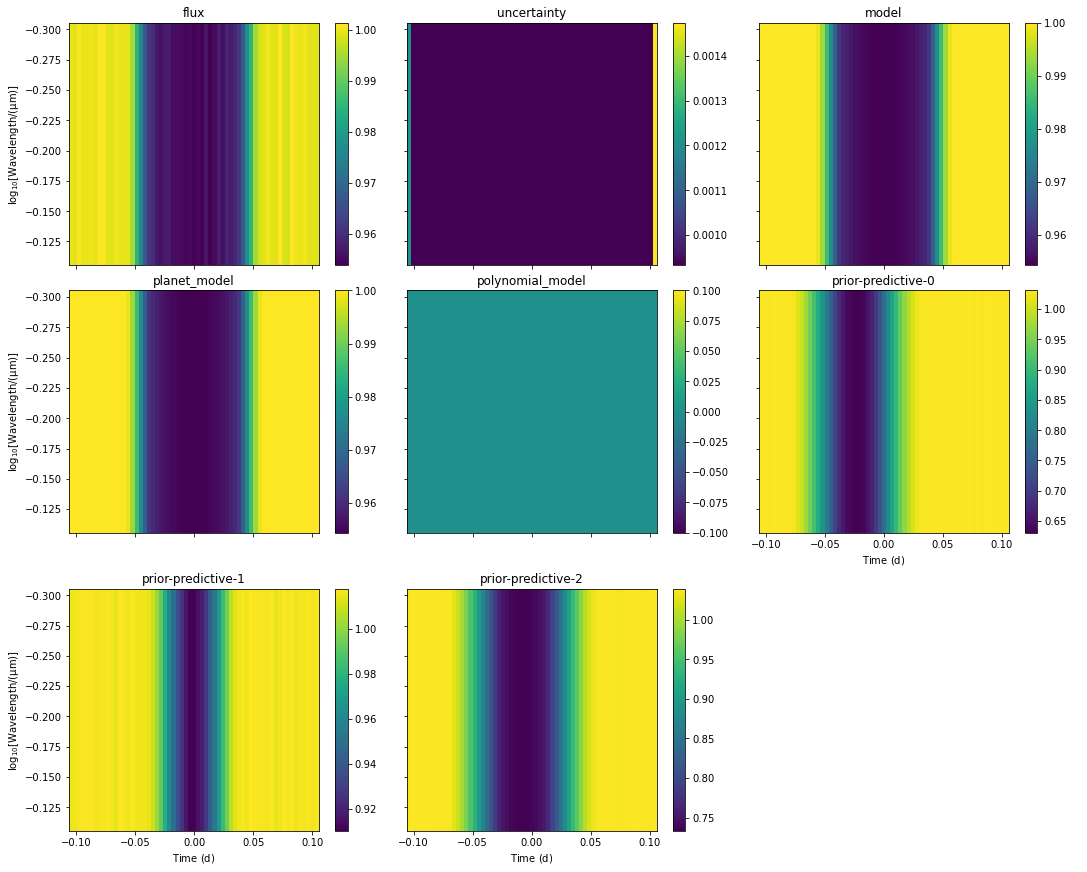

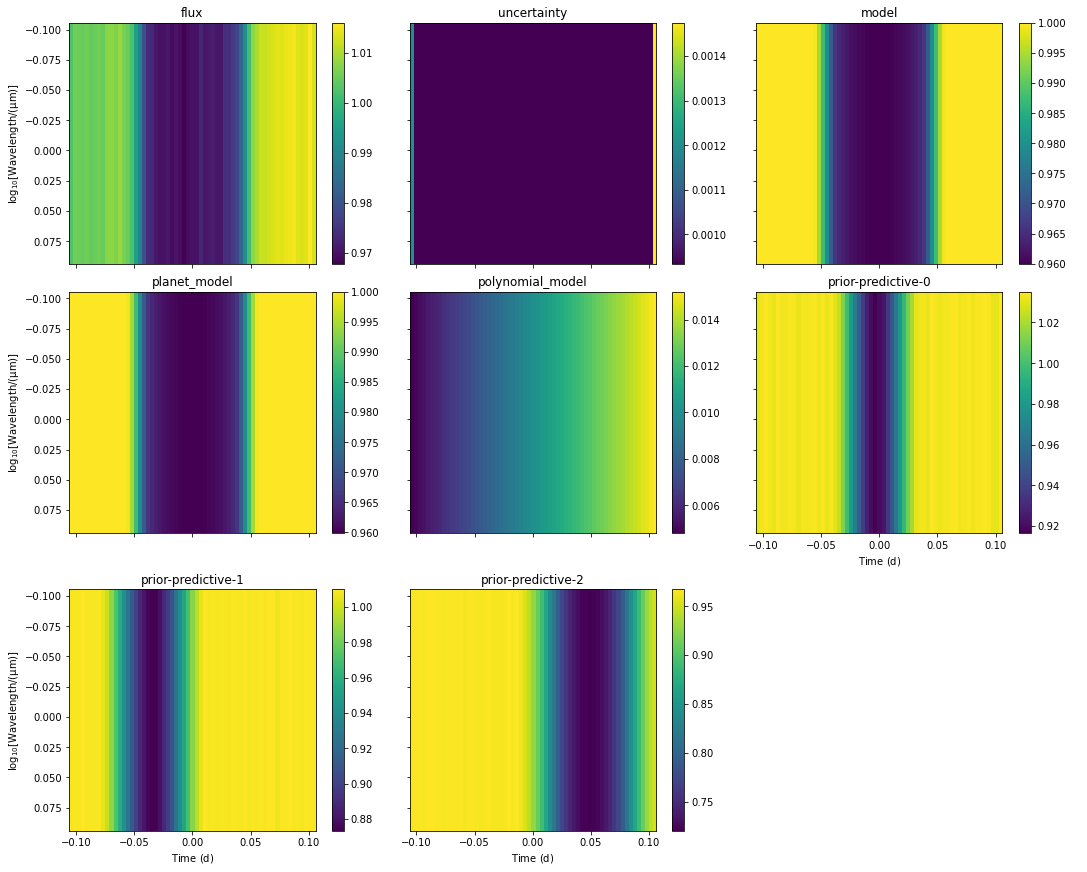

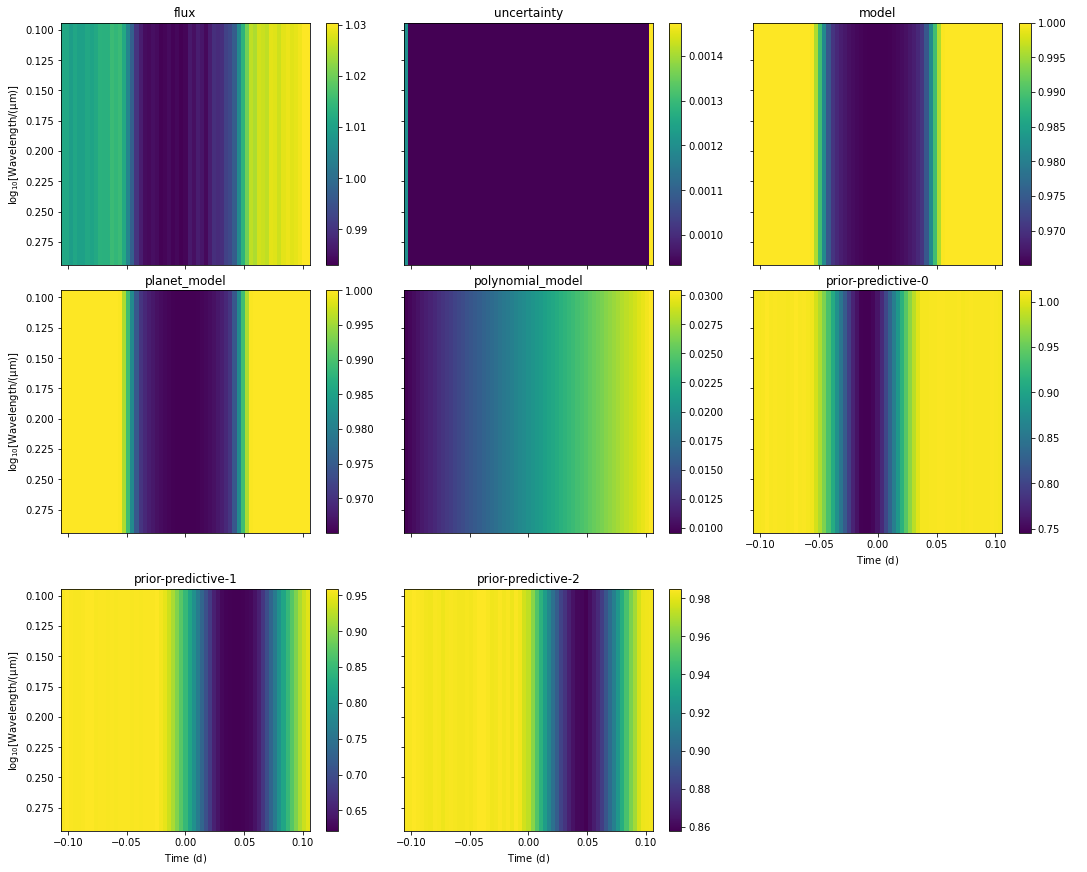

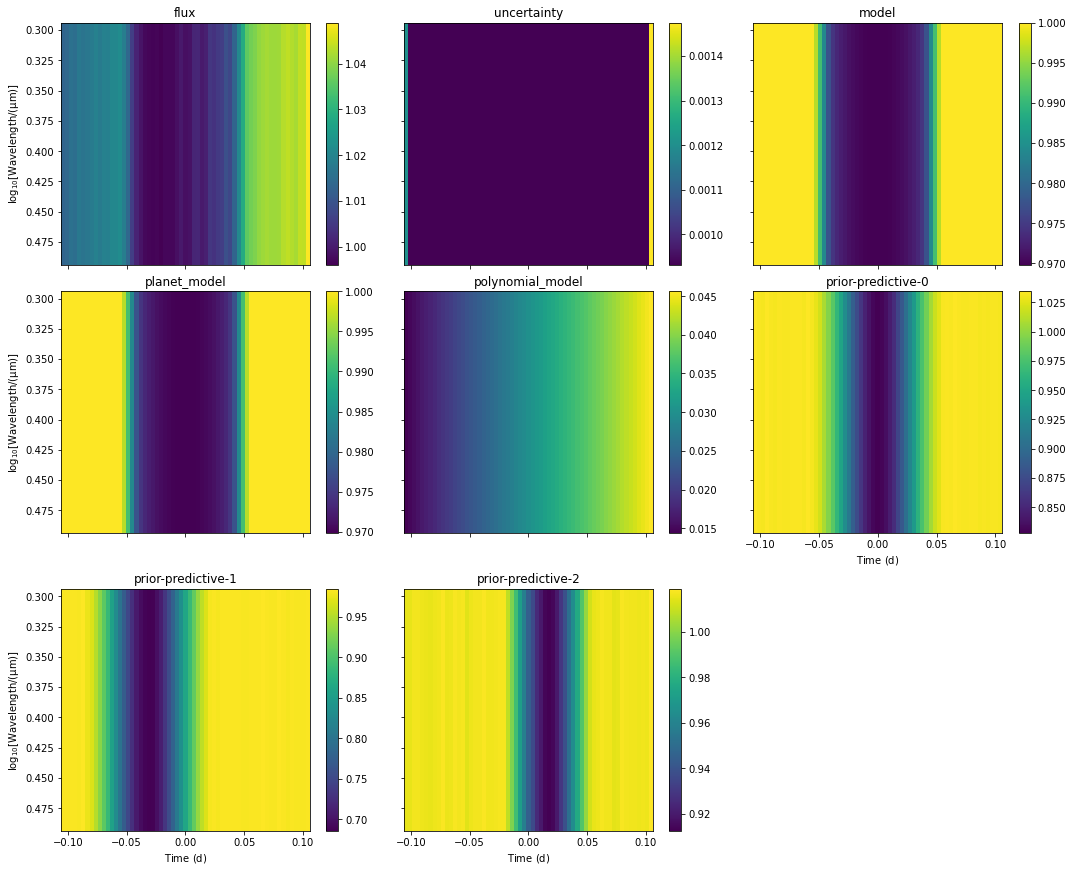

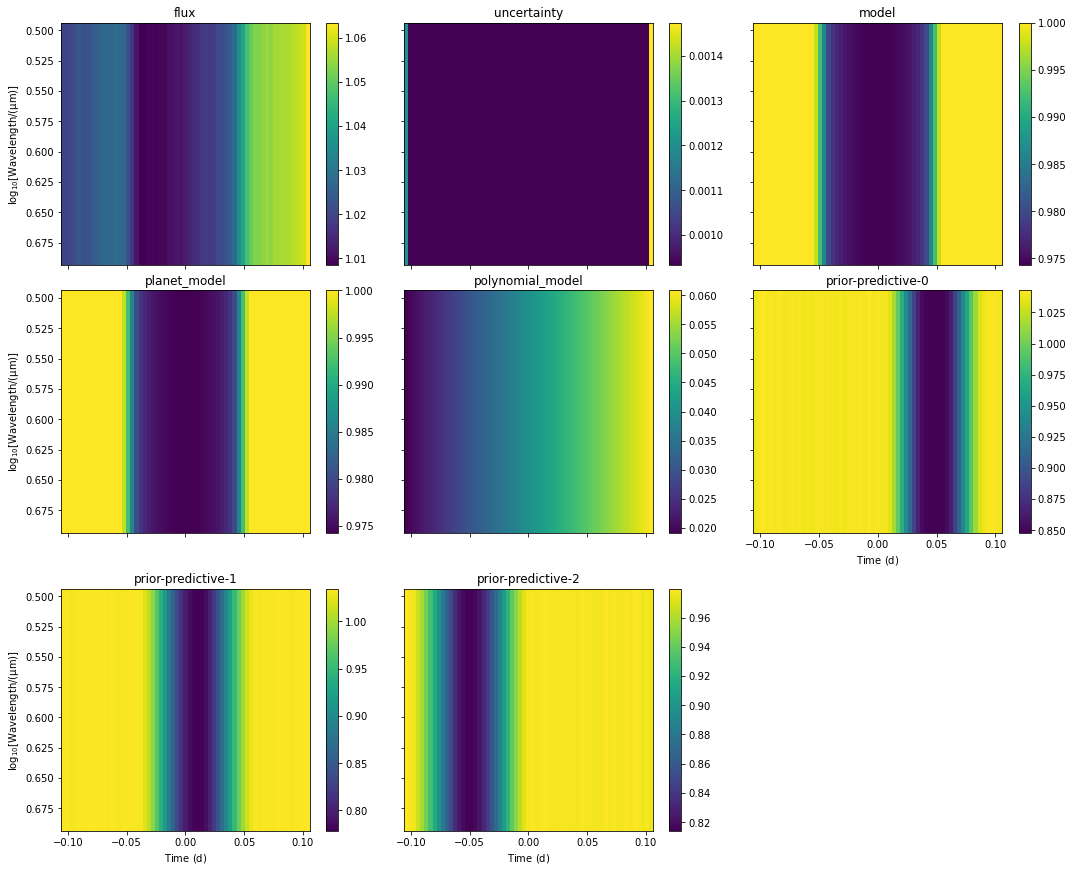

In [7]:
t.plot_priors()

In [8]:
t.sample()
t.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass_w0, stellar_radius_w0, impact_parameter_w0, epoch_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7994265367192, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w1, radius_ratio_w1, limb_darkening_w1, stellar_mass_w1, stellar_rad

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w2, radius_ratio_w2, limb_darkening_w2, stellar_mass_w2, stellar_radius_w2, impact_parameter_w2, epoch_w2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9666010157911308, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w3, radius_ratio_w3, limb_darkening_w3, stellar_mass_w3, stellar_radius_w3, impact_parameter_w3, epoch_w3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4, stellar_mass_w4, stellar_radius_w4, impact_parameter_w4, epoch_w4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

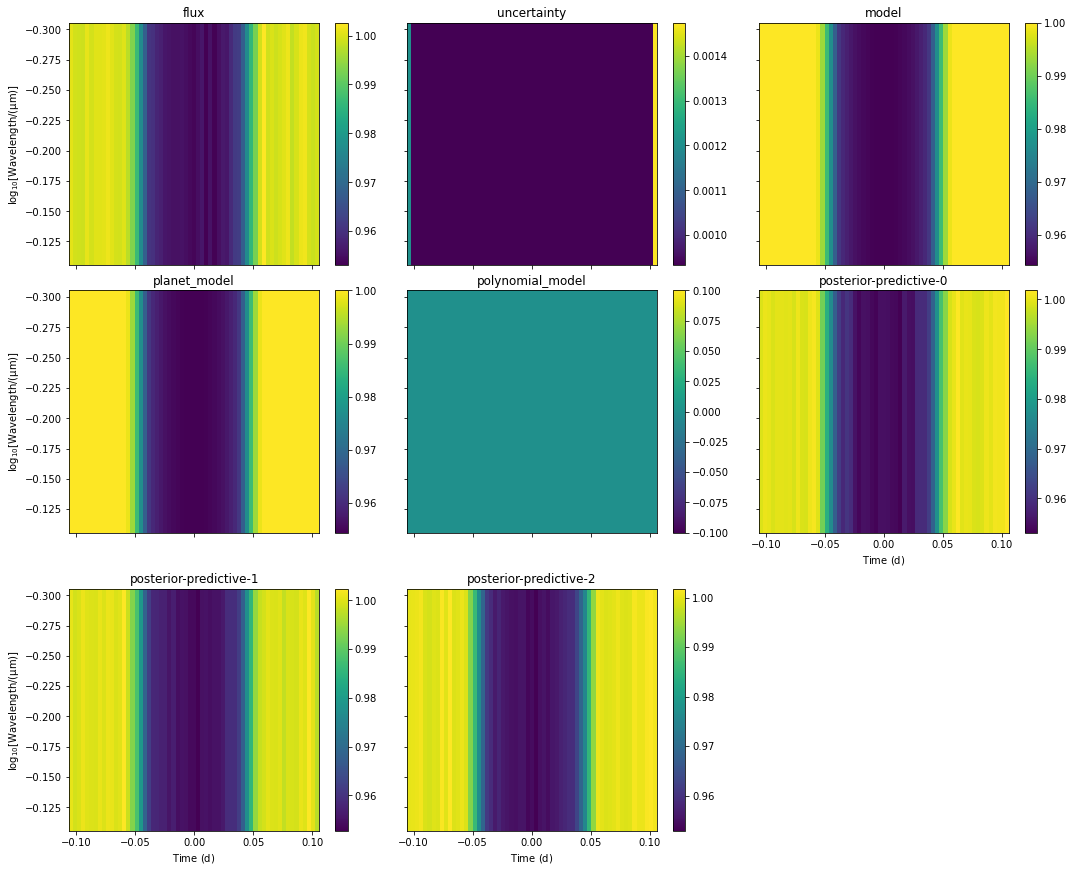

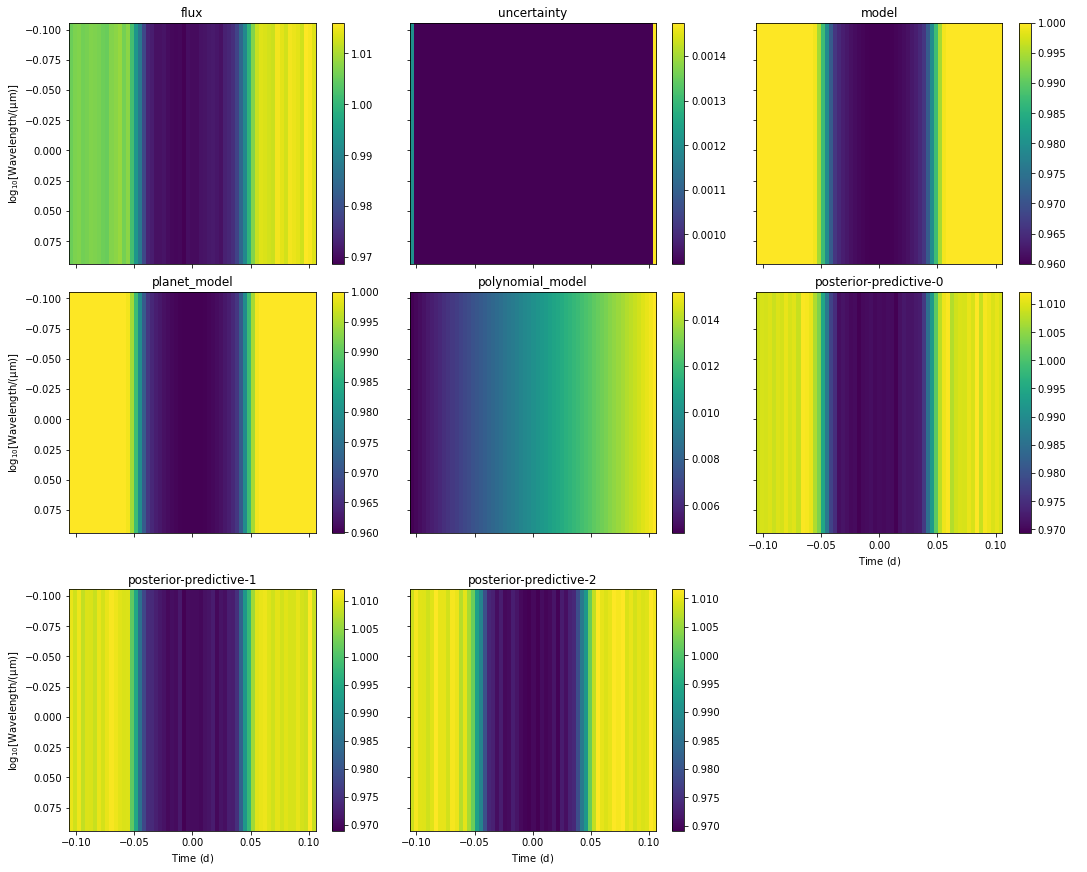

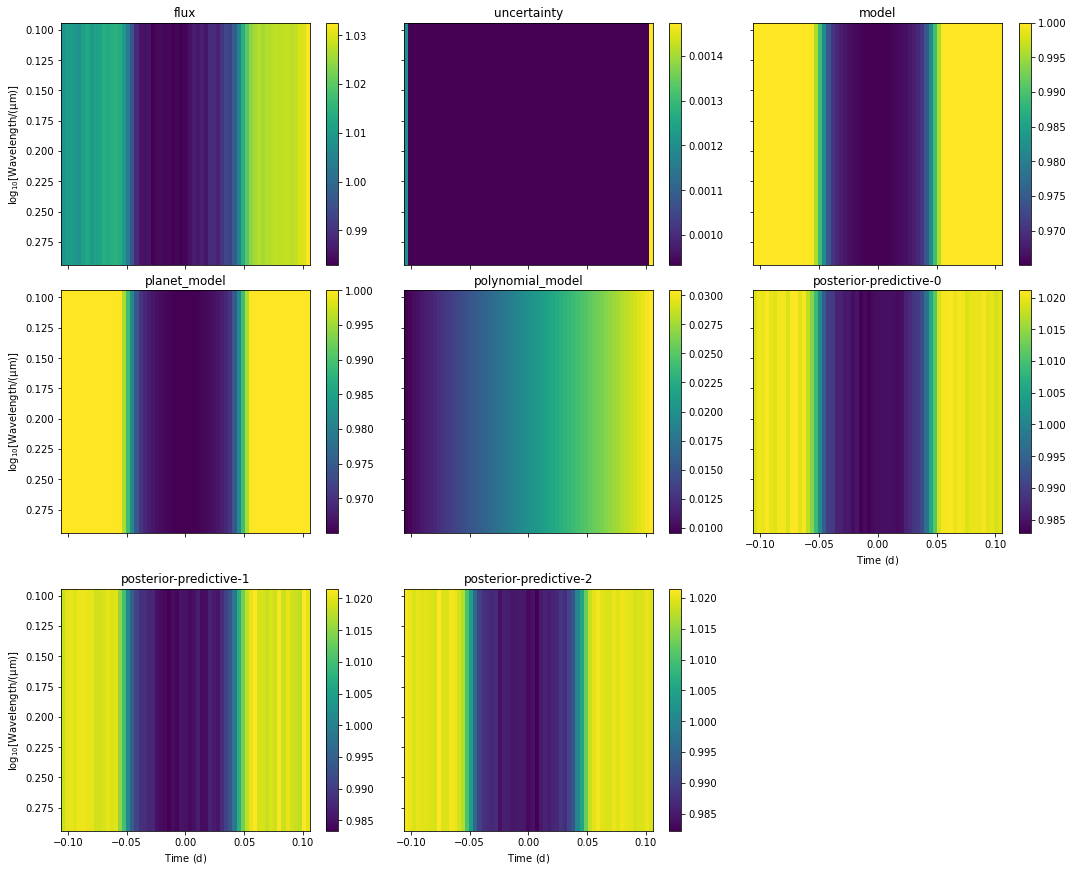

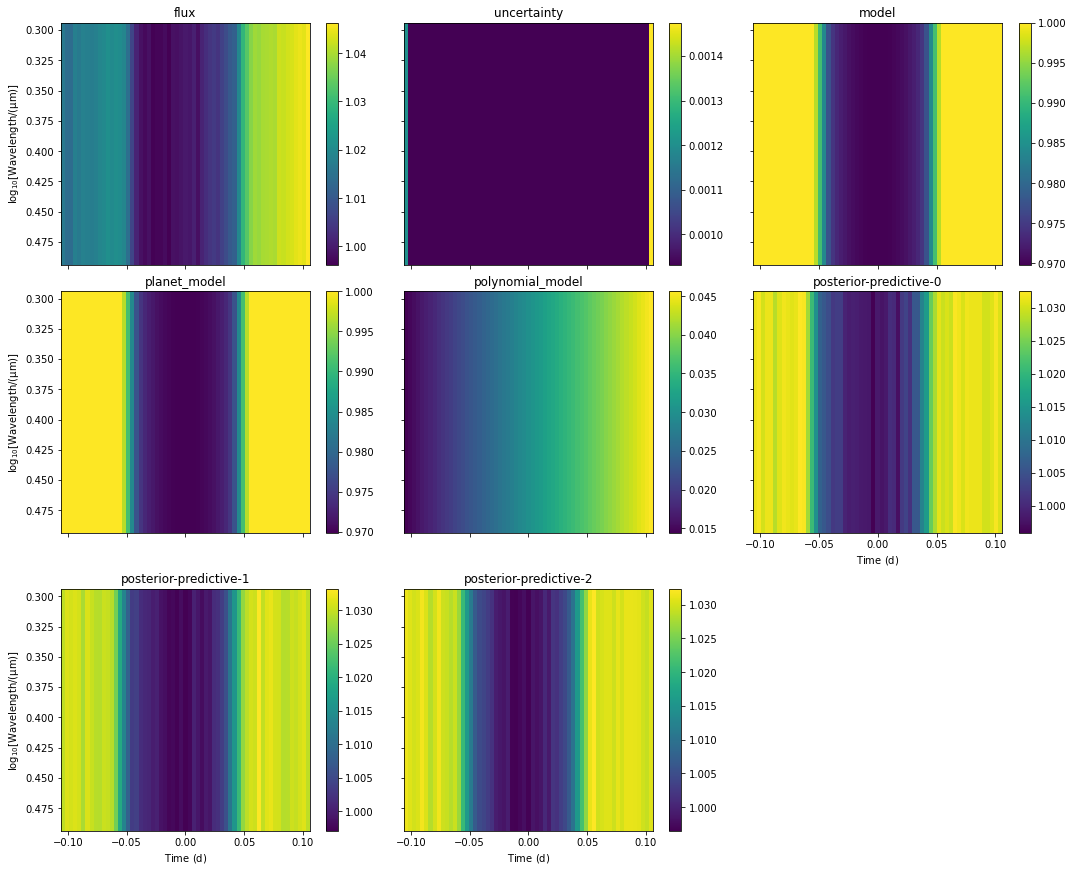

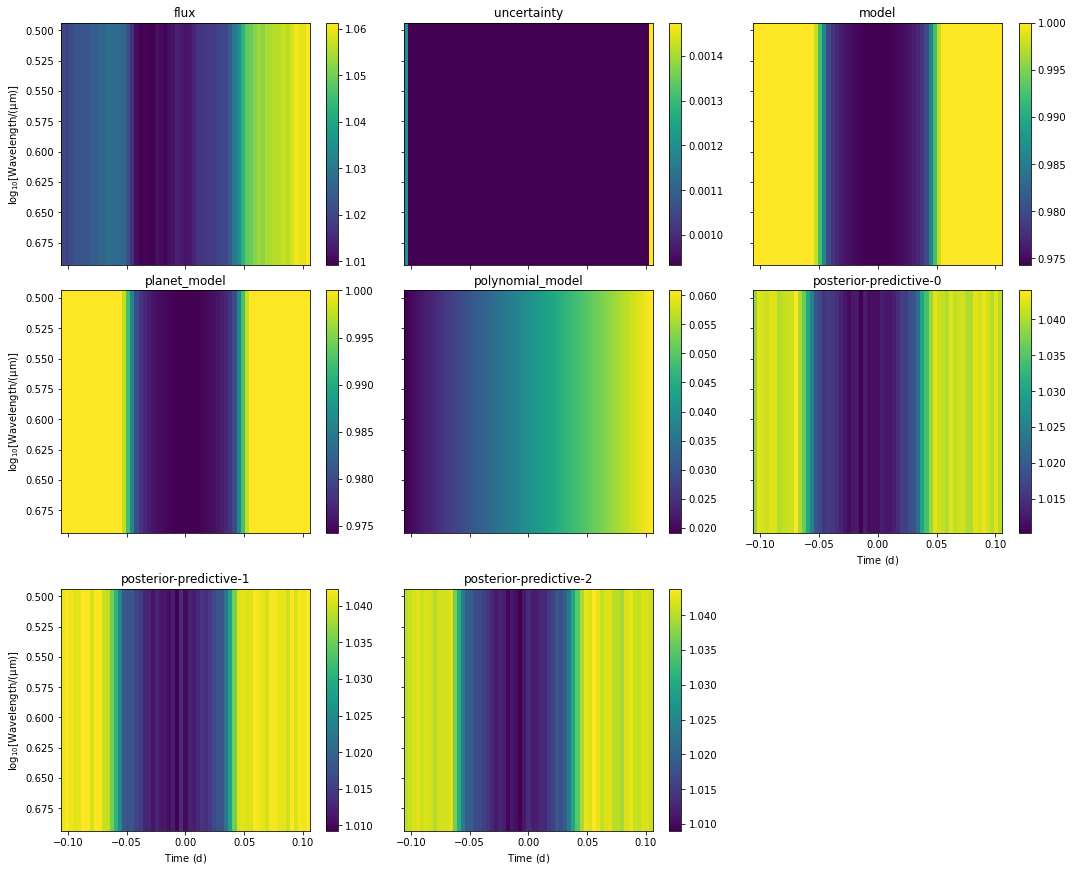

In [9]:
t.plot_posteriors()

# Combined Model!

In [26]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t,'polynomial':b})
cm.attach_data(r)
cm.choose_optimization_method("separate")
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16131.94it/s]


{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}
[<pymc3.model.Model object at 0x1c641c610>, <pymc3.model.Model object at 0x1ca9d4310>, <pymc3.model.Model object at 0x1caa54be0>, <pymc3.model.Model object at 0x1caa54eb0>, <pymc3.model.Model object at 0x1cadf5070>]



🌈 Warning: invalid value encountered in log

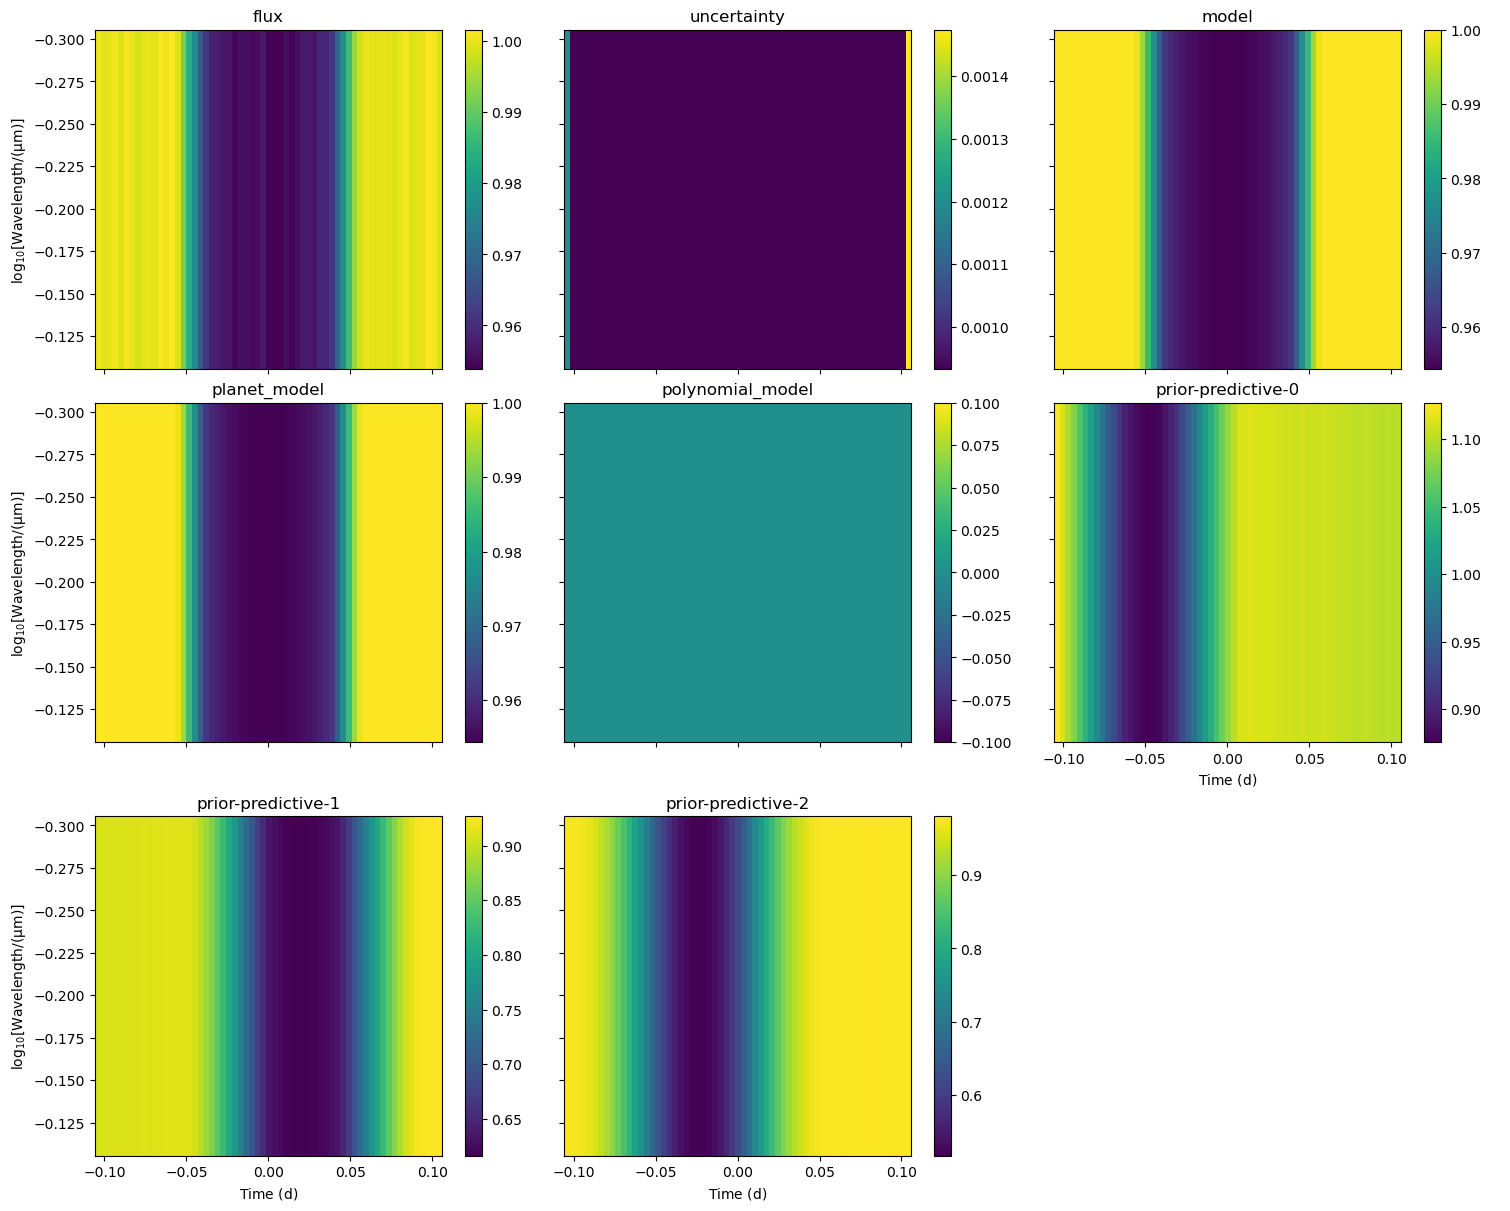

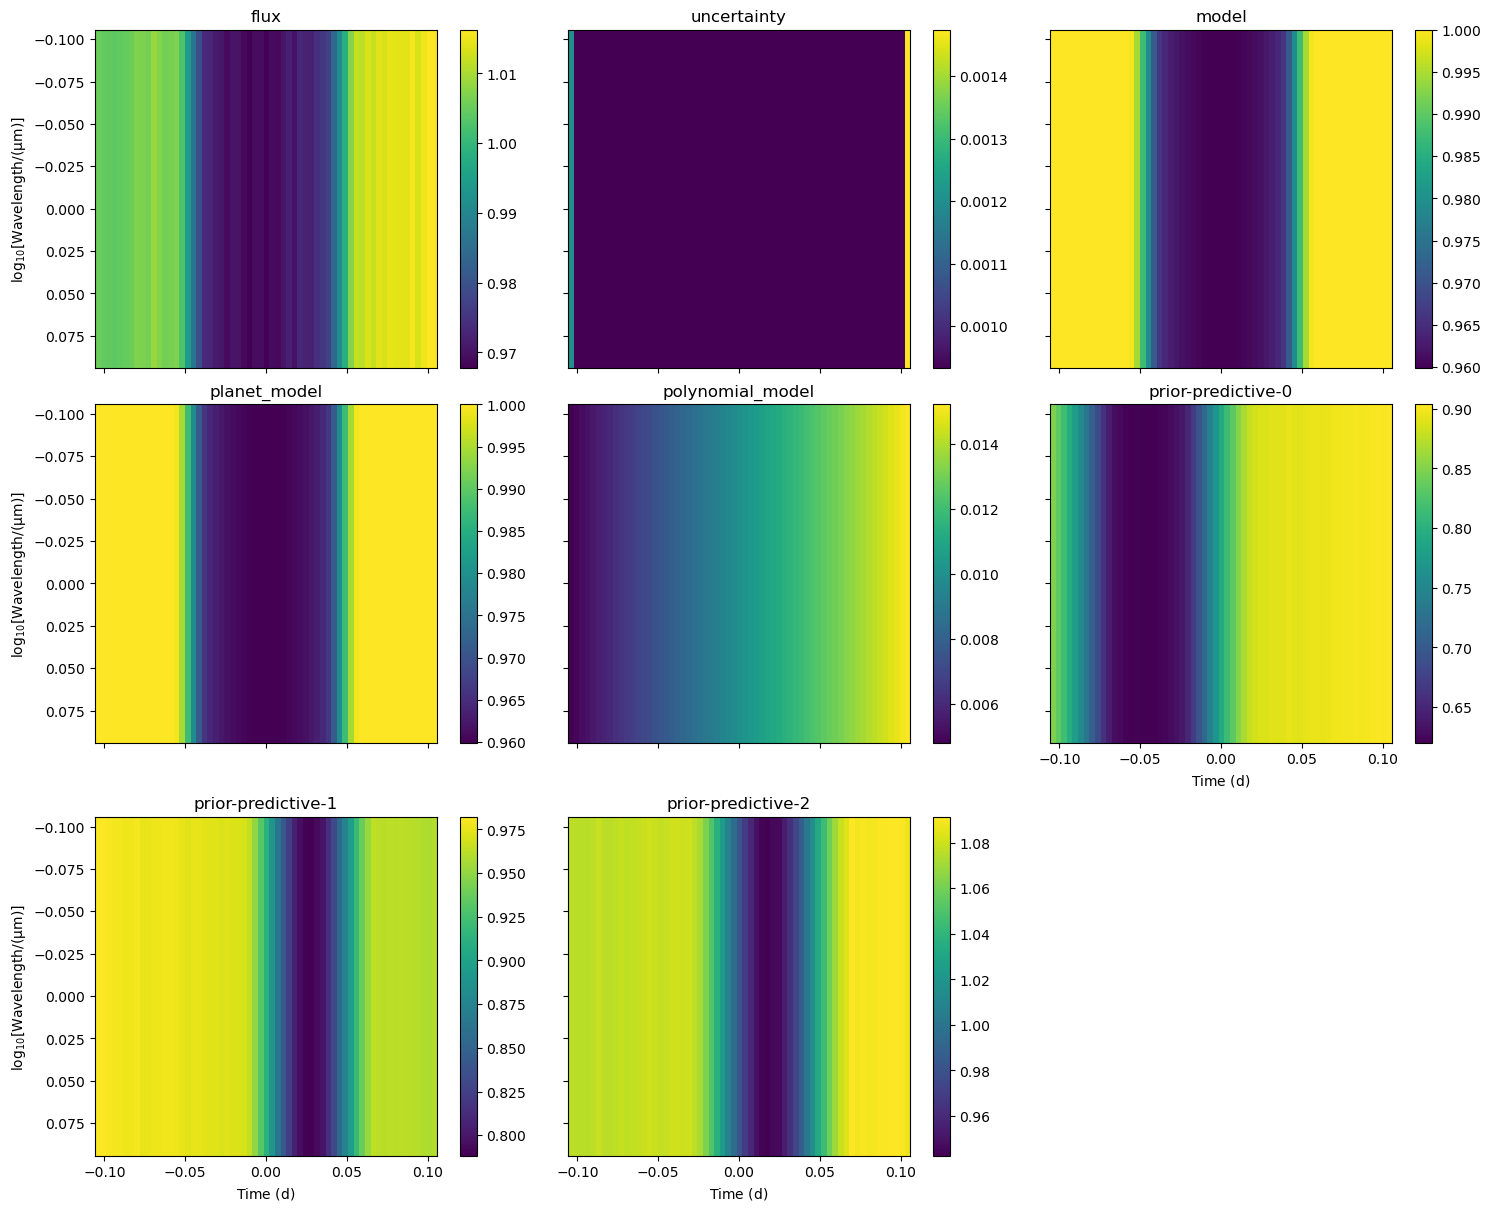

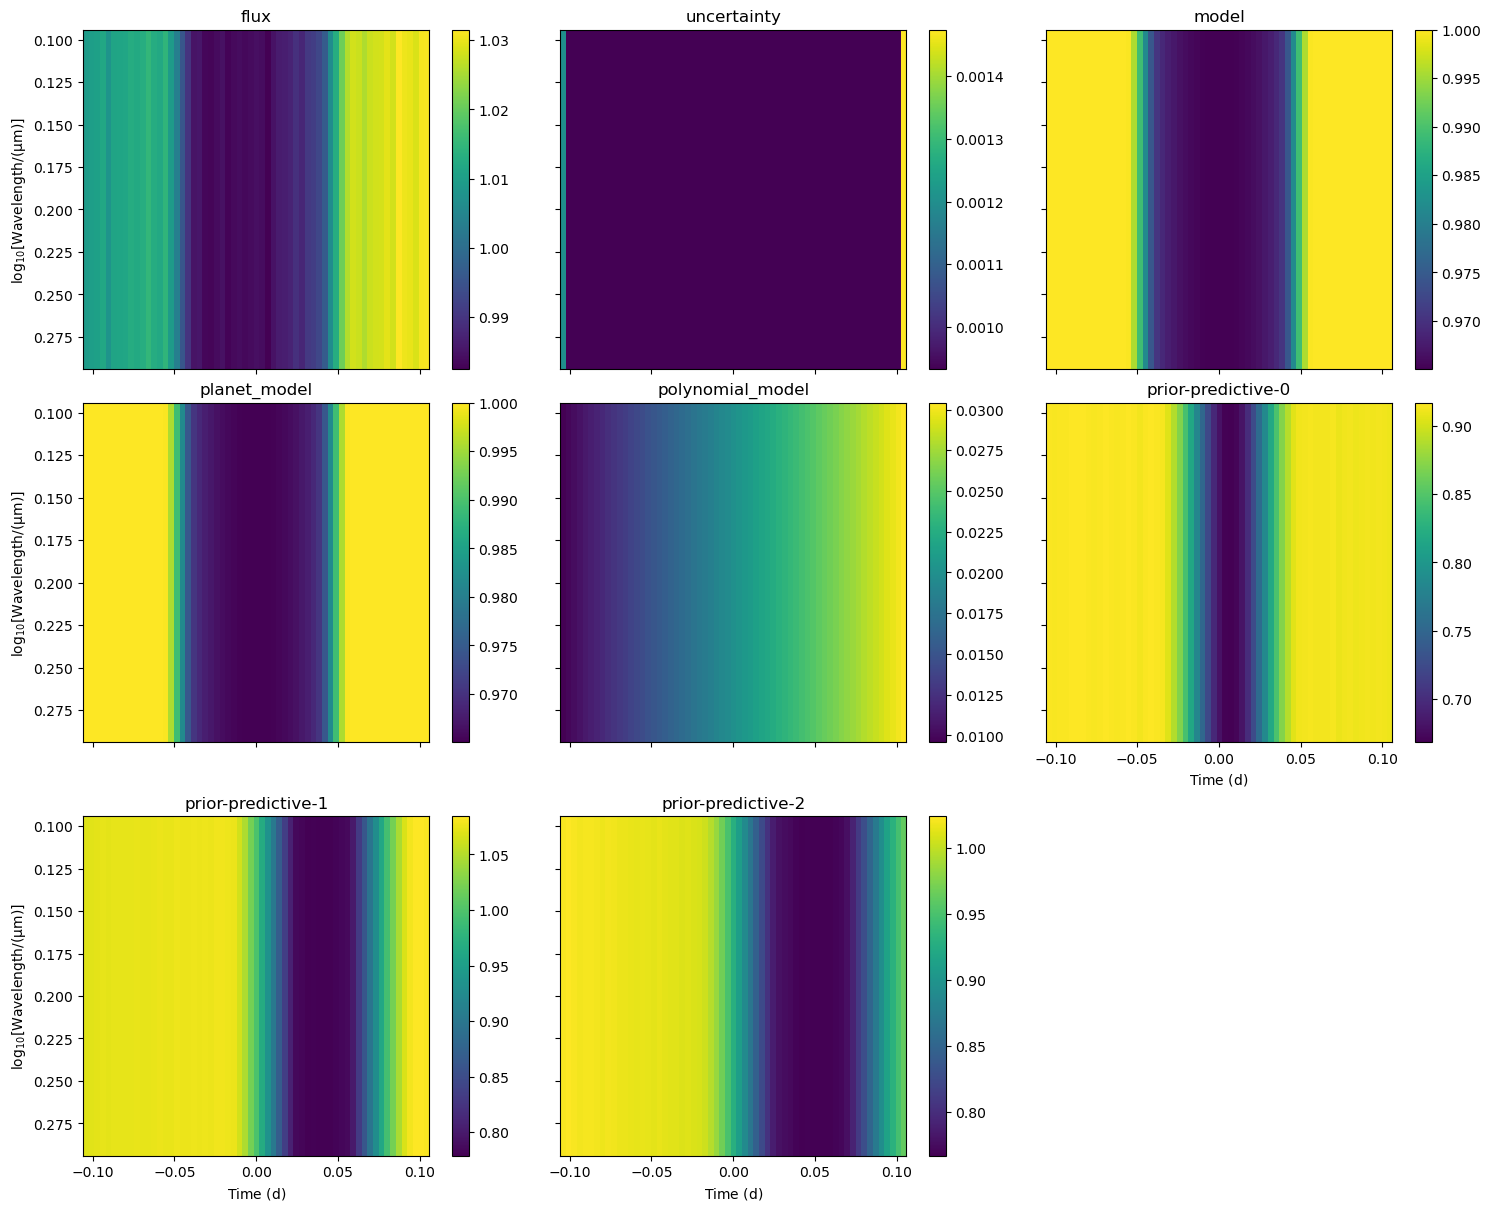

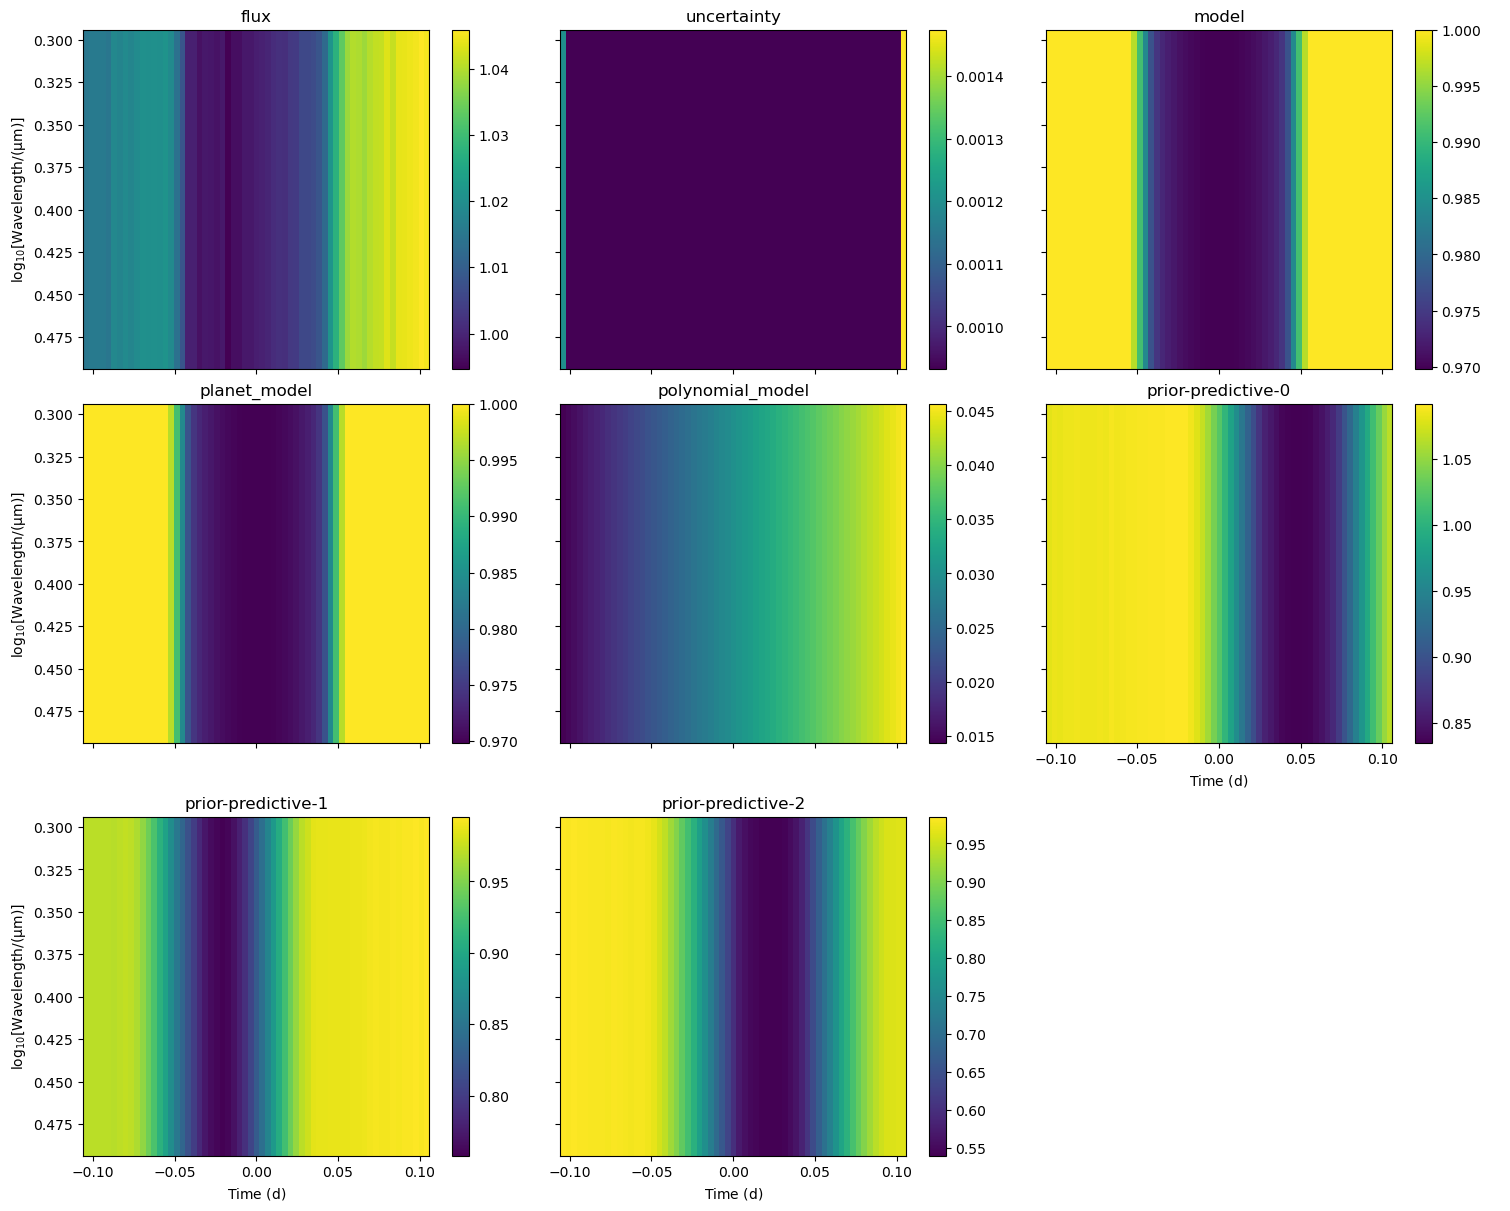

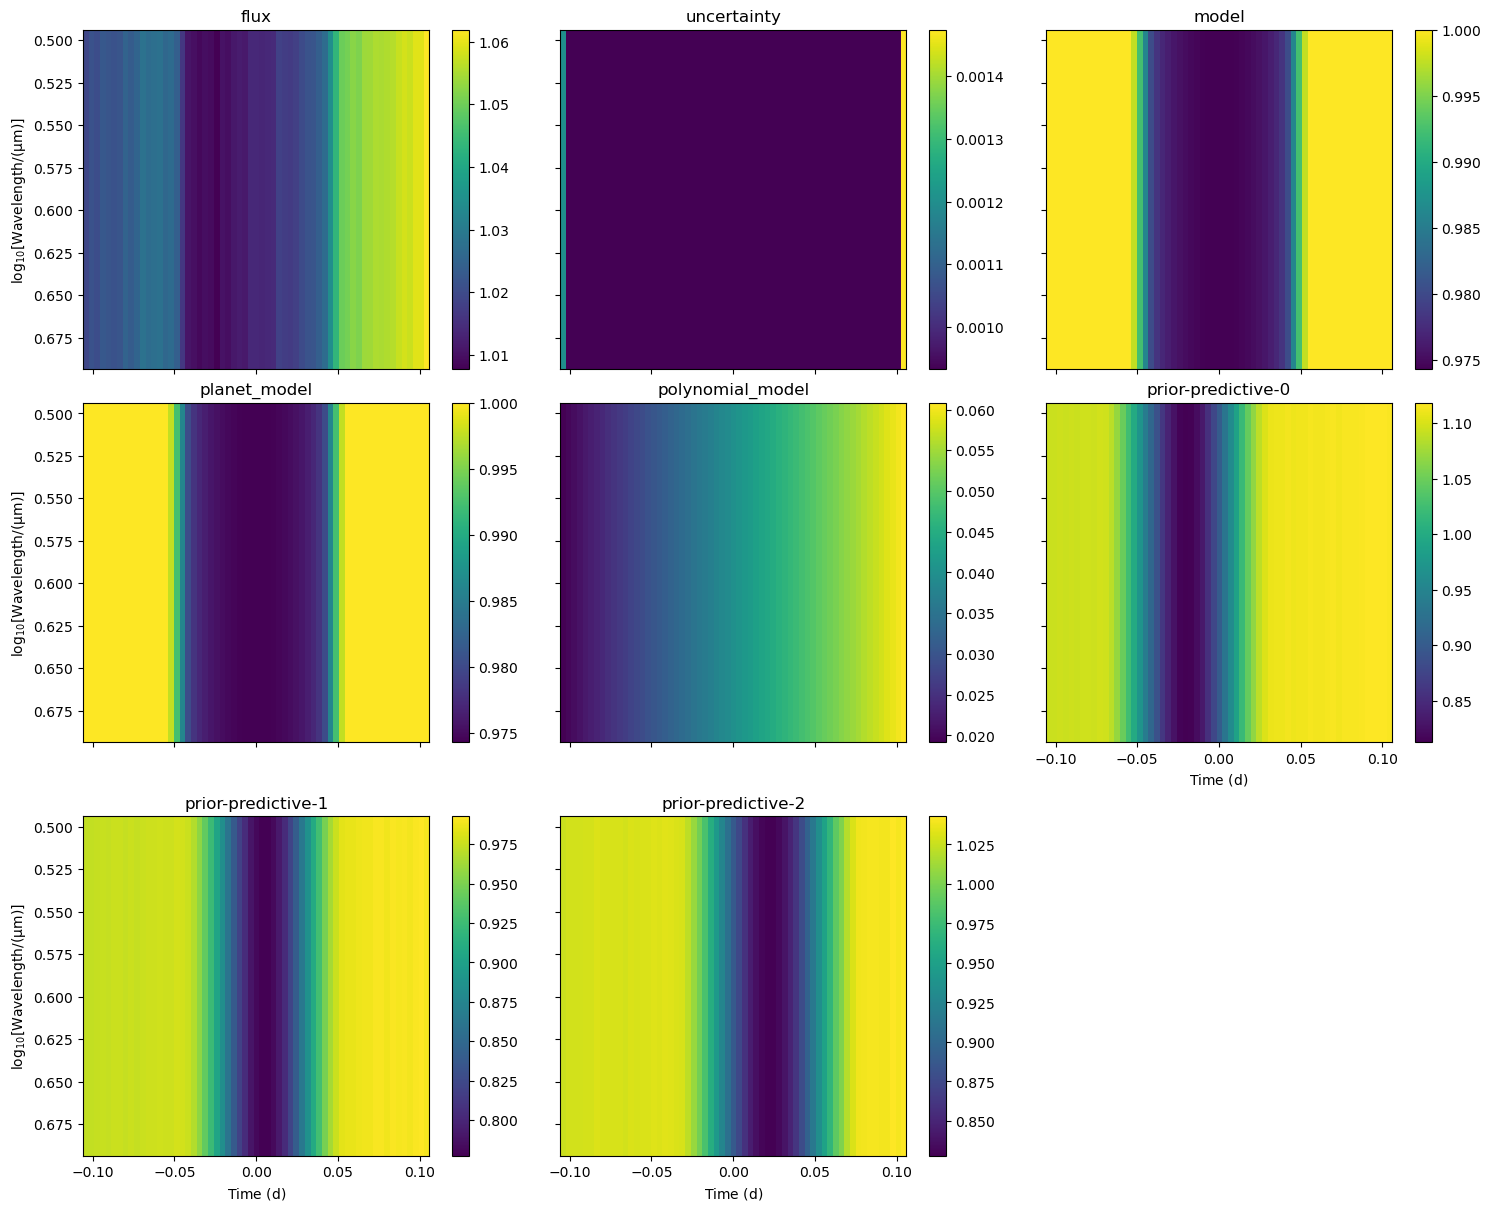

In [27]:
cm.plot_priors()

In [28]:
# cm.sample(tune=8000, draws=8000, cores=12, chains=4)
# opt = optimize(start=t.model.test_point)
cm.sample()
cm.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_w0, baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass_w0, stellar_radius_w0, impact_parameter_w0, epoch_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6905274583005819, but should be close to 0.9. Try to increase the number of tuning steps.
There were 585 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3620677004651187, but should be close to 0.9. Try to increase the number of tuning steps.
There were 403 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.490884538107287, but should be close to 0.9. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8391109284624991, but should be close to 0.9. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_w2, baseline_w2, radius_ratio_w2, limb_darkening_w2, st

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9640410785986717, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Mul

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_w4, baseline_w4, radius_ratio_w4, limb_darkening_w4, stellar_mass_w4, stellar_radius_w4, impact_para

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8405372971859818, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [29]:
cm.summary

[                          mean        sd    hdi_3%   hdi_97%  mcse_mean  \
 radius_ratio_w0       0.203677  0.001927  0.201061  0.207021   0.000693   
 epoch_w0             -0.000408  0.000137 -0.000628 -0.000158   0.000040   
 impact_parameter_w0   0.135703  0.100590  0.014751  0.304575   0.040252   
 stellar_radius_w0     1.179749  0.015104  1.151258  1.199955   0.005332   
 stellar_mass_w0       0.847950  0.028774  0.800020  0.894231   0.007504   
 limb_darkening_w0[0]  0.192292  0.082005  0.062534  0.352171   0.025014   
 limb_darkening_w0[1]  0.144473  0.210202 -0.140319  0.465377   0.075887   
 baseline_w0           1.019754  0.021894  0.977602  1.040548   0.008705   
 p_w0[0]              -0.019639  0.021874 -0.040436  0.022549   0.008688   
 p_w0[1]              -0.000565  0.002178 -0.003979  0.002898   0.000814   
 
                        mcse_sd   ess_bulk    ess_tail     r_hat  
 radius_ratio_w0       0.000511   8.920330   85.731842  1.374465  
 epoch_w0              0.000


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

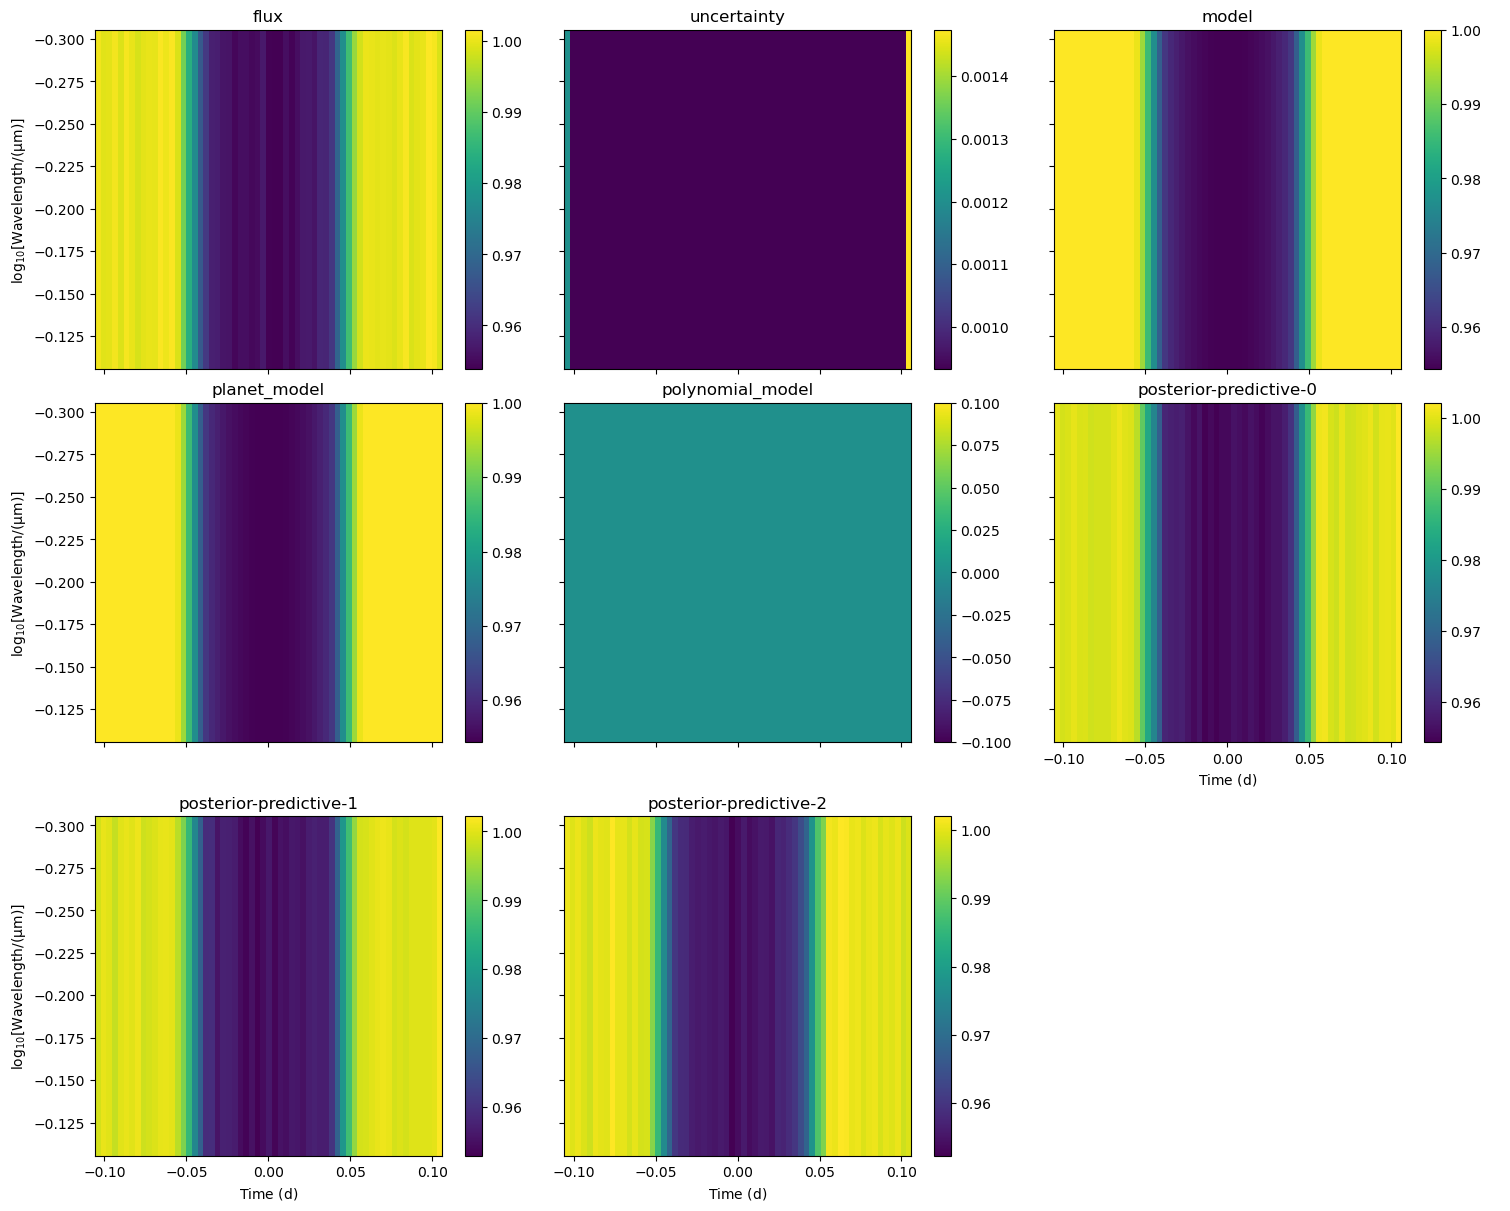

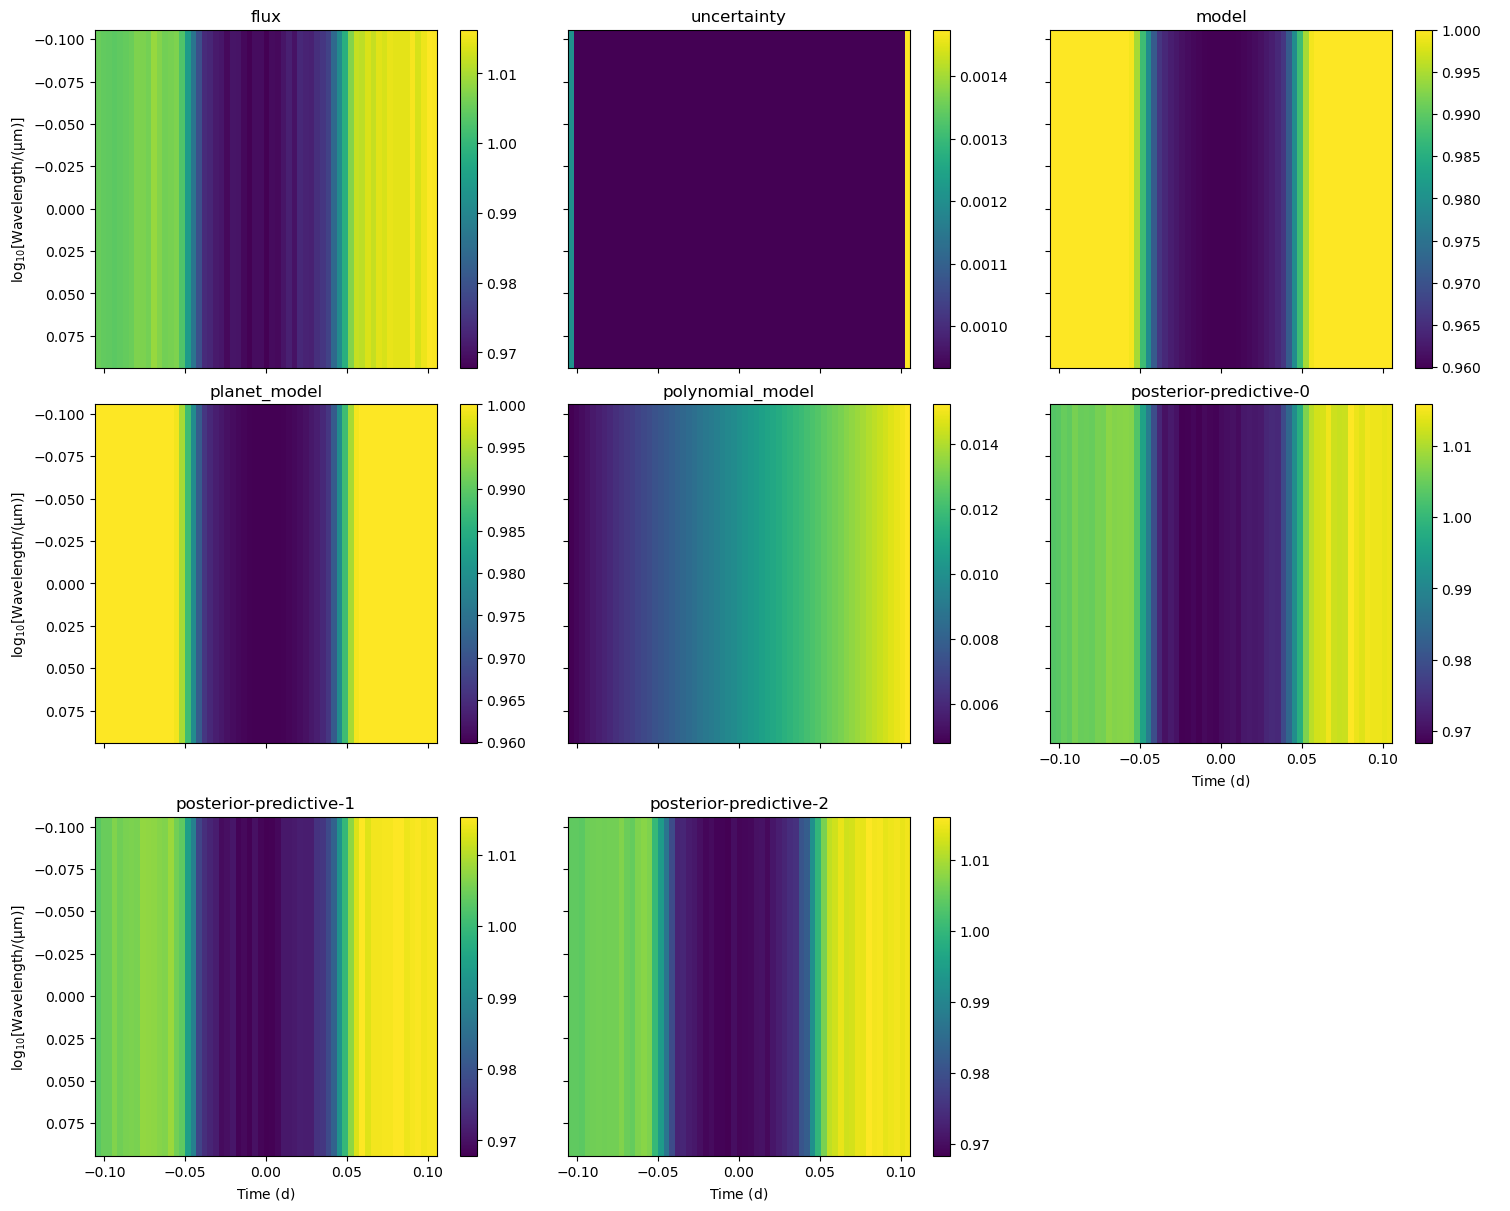

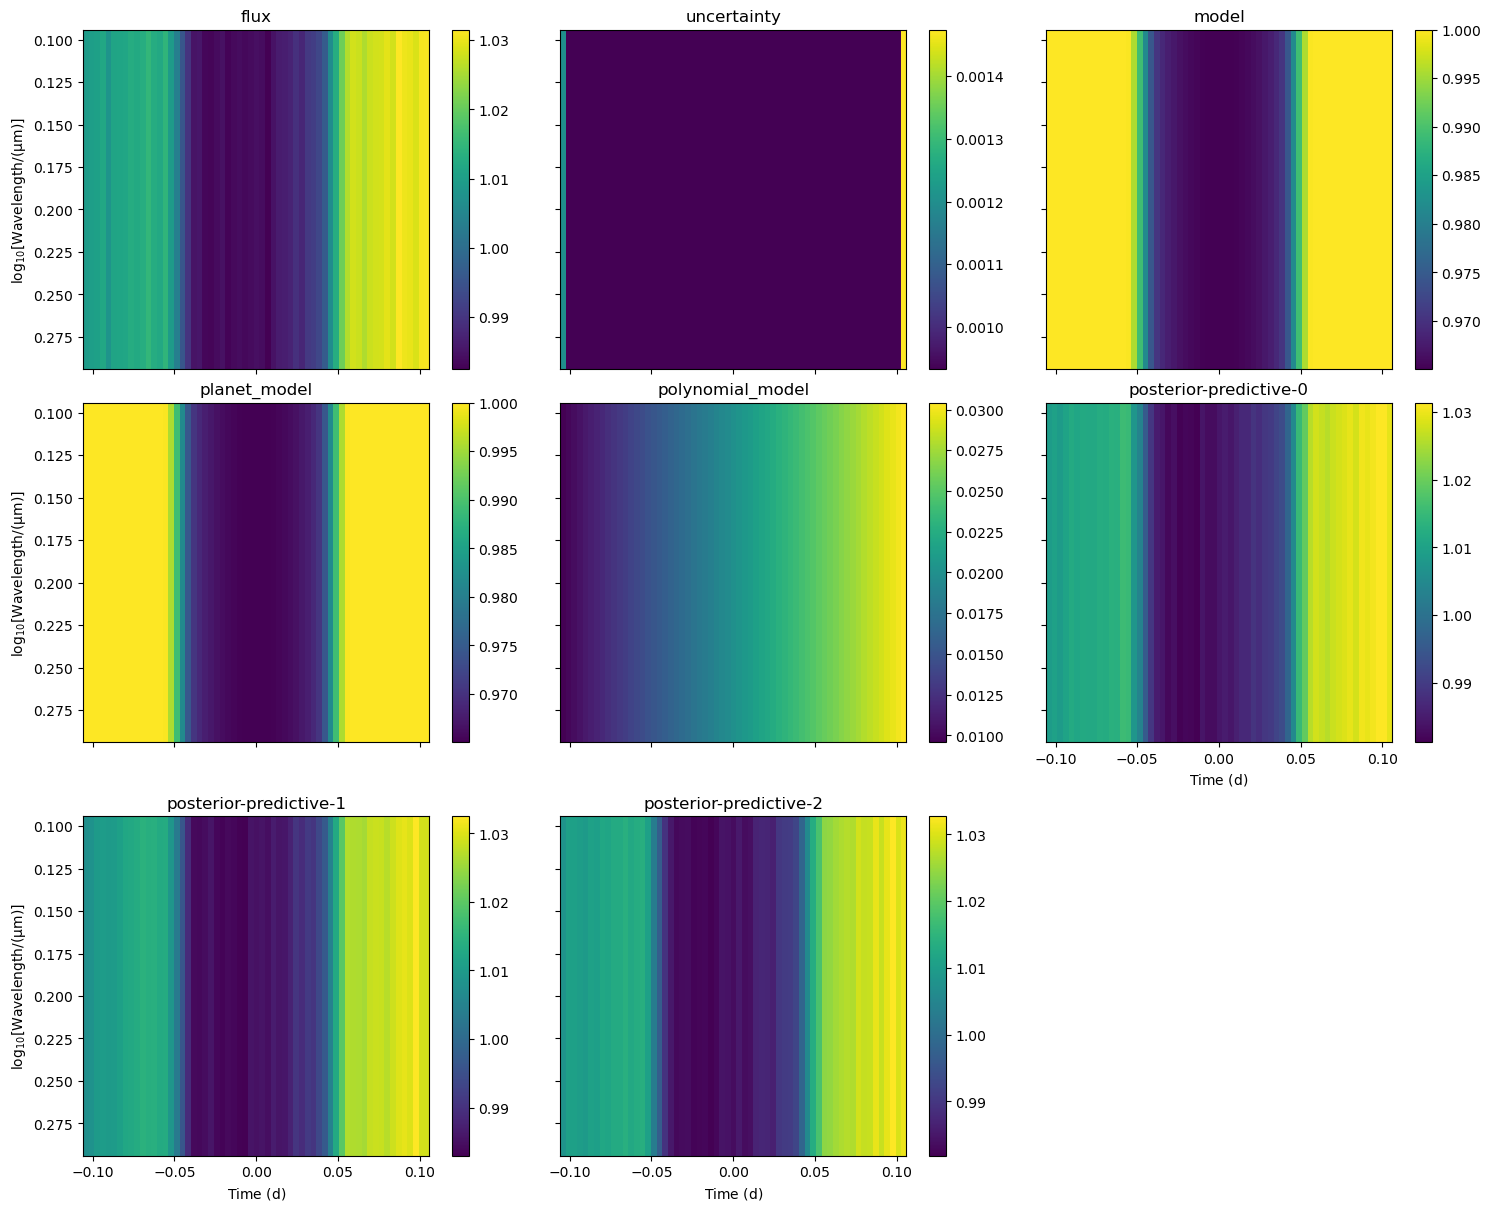

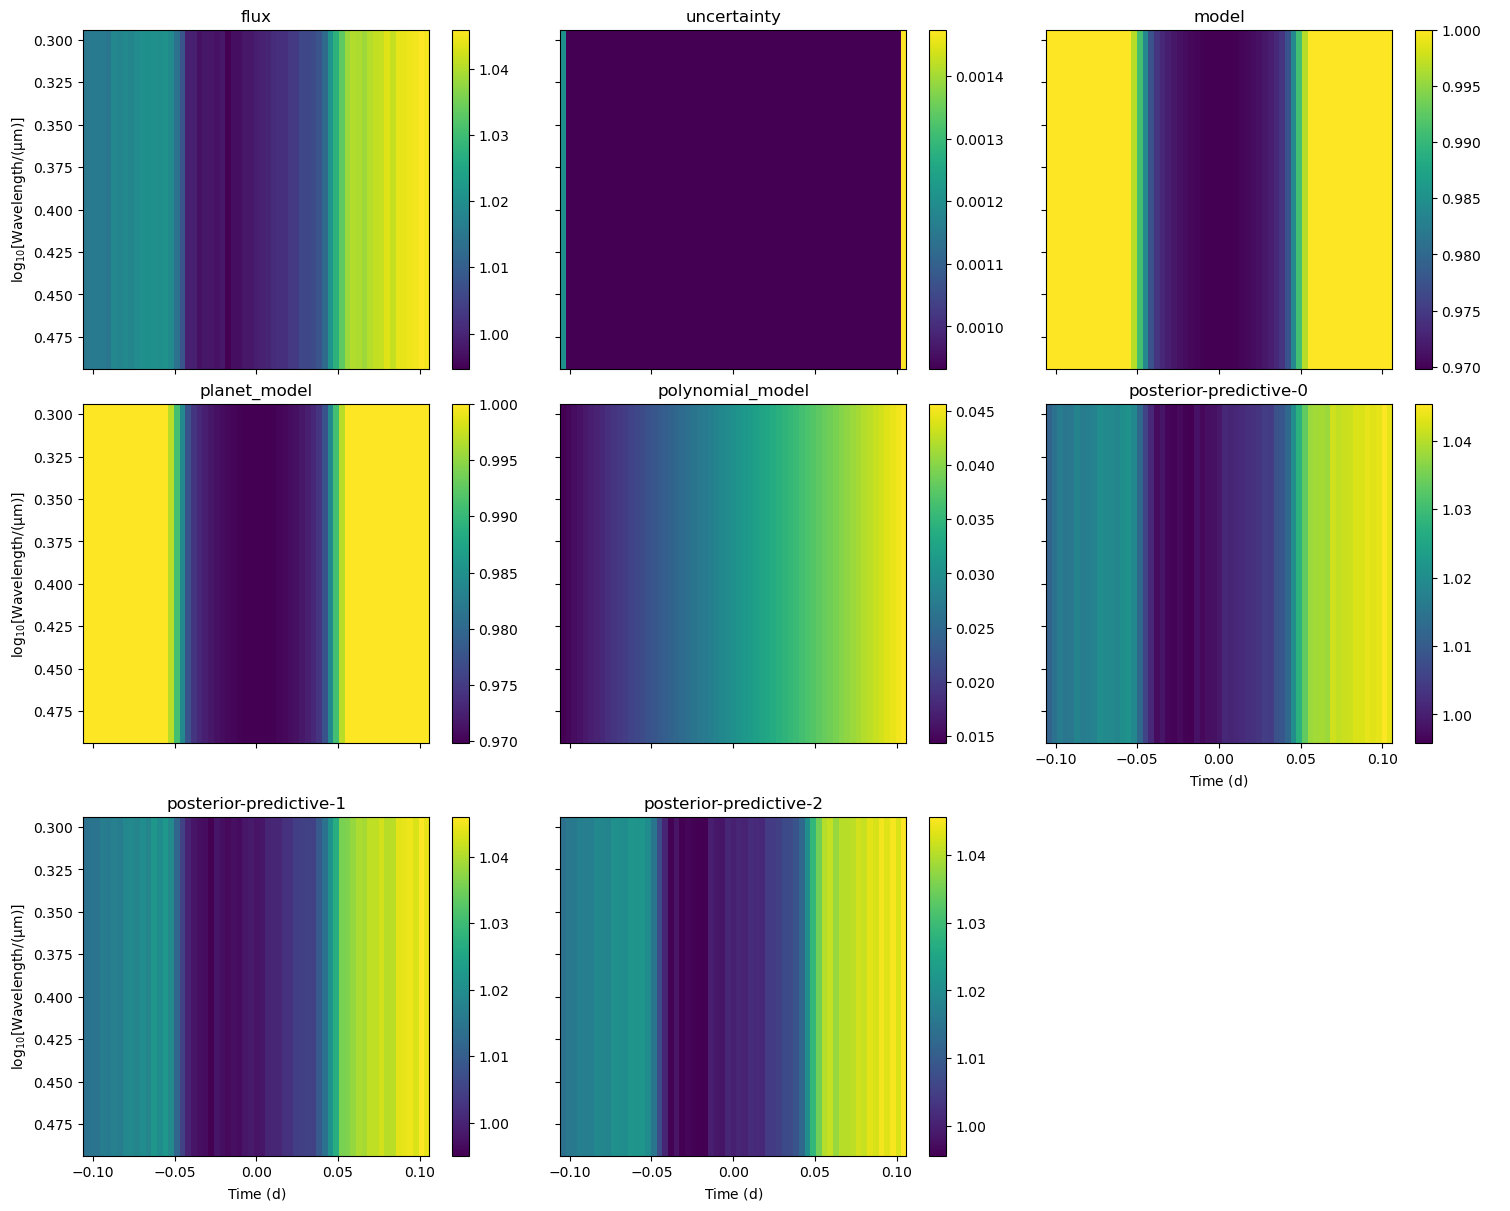

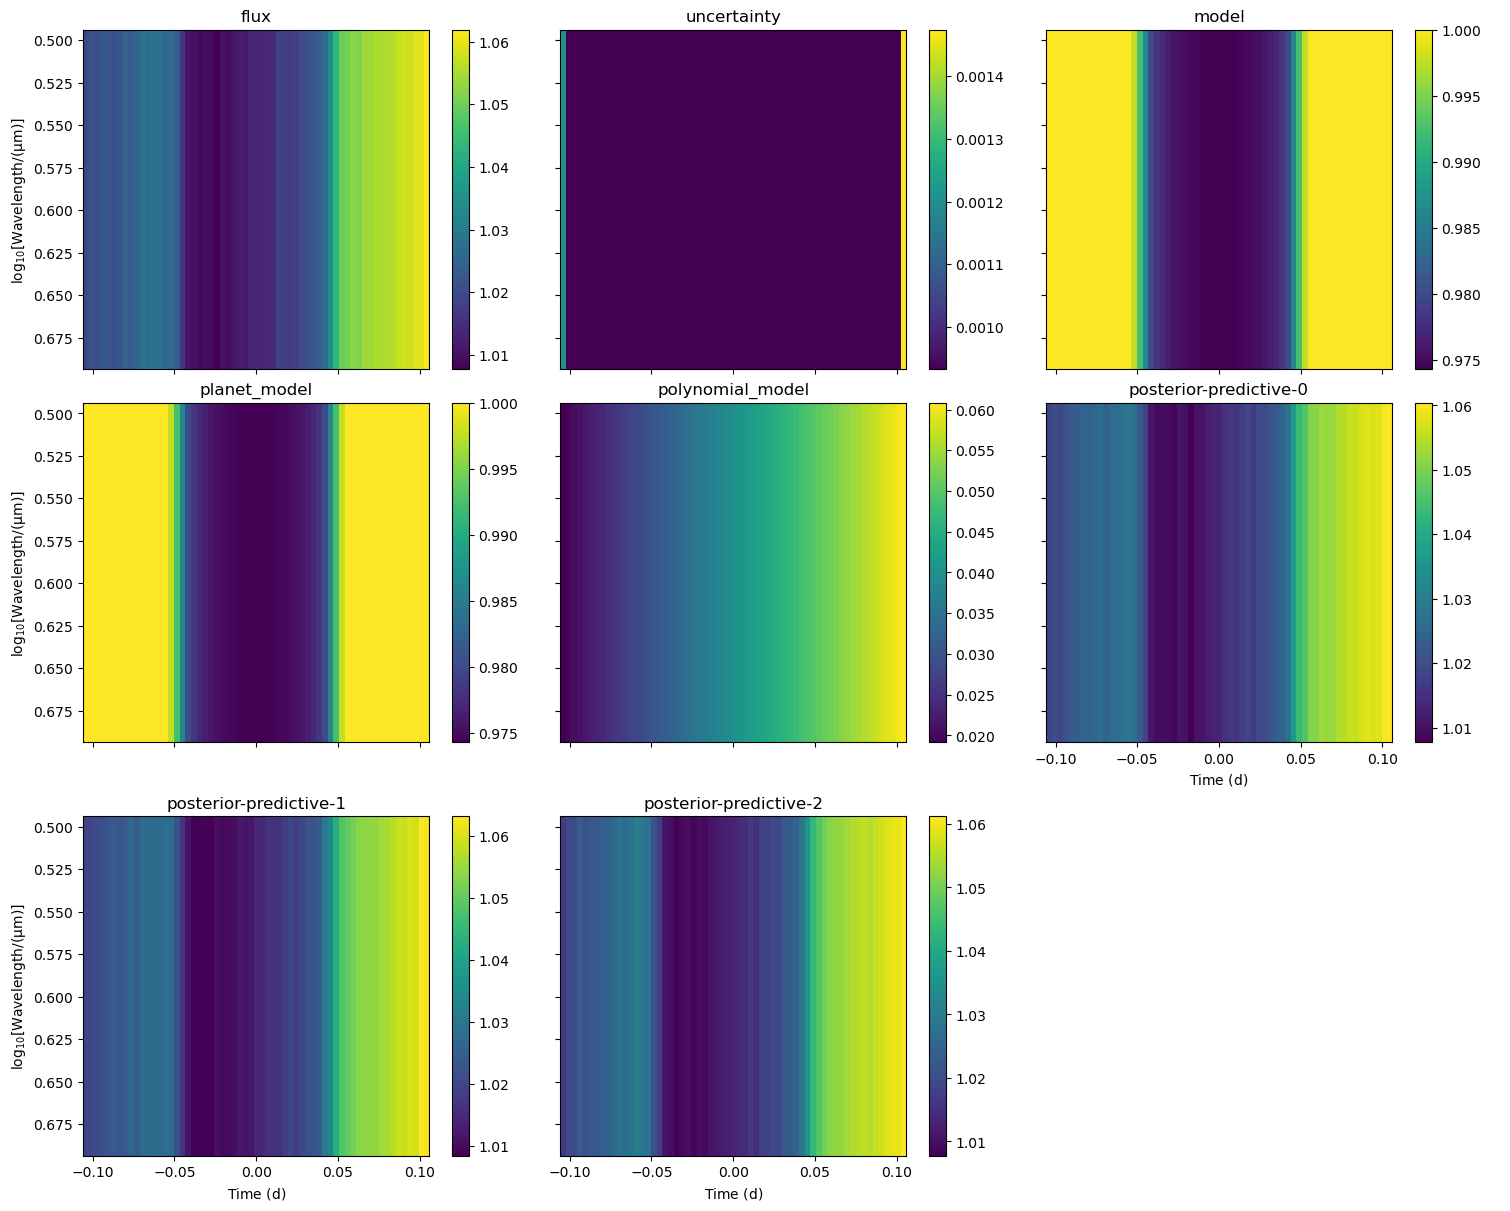

In [30]:
cm.plot_posteriors()

In [31]:
cm_copy = cm


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

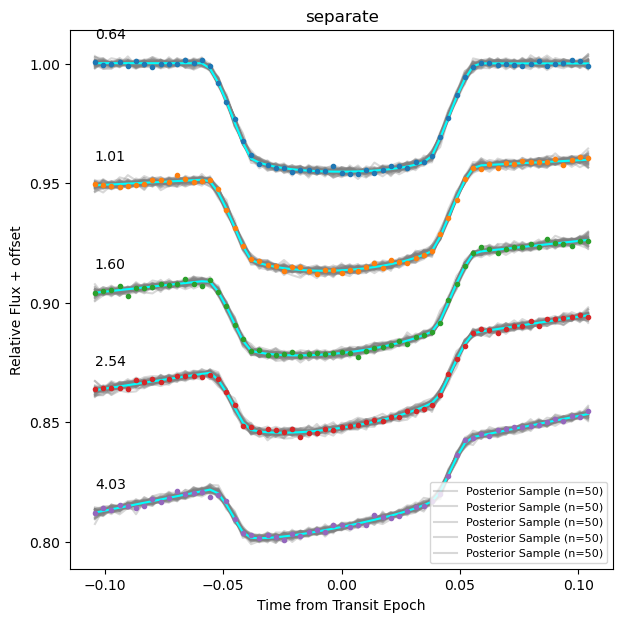

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
from matplotlib.pyplot import cm as cmap

posterior_predictive_traces = cm.sample_posterior(ndraws=50)

for j, (mod, trace, summary, posterior_predictive_trace) in enumerate(zip(cm.pymc3_model, cm.trace, cm.summary, posterior_predictive_traces)):
    if cm.optimization == 'separate':
        data = cm.get_data(j)
    else:
        data = cm.get_data()
        
    spacing = 3 * np.nanstd(data.flux)

    color=cmap.viridis(np.linspace(0,1,data.nwave))

    posterior_means = summary['mean']

    # spacing = ax._most_recent_chromatic_plot_spacing
    for i, w in enumerate(data.wavelength):
        firstplot = True
        transit_params = extract_mean_posteriors(cm.chromatic_models['transit'],summary, i+j)#cm.chromatic_models['transit'].extract_mean_posteriors(summary, i+j)
        poly_params = extract_mean_posteriors(cm.chromatic_models['polynomial'],summary, i+j)#cm.chromatic_models['polynomial'].extract_mean_posteriors(summary, i+j)

        poly = cm.chromatic_models['polynomial'].polynomial_model(poly_params)
        transit = cm.chromatic_models['transit'].transit_model(transit_params)

        for k in range(50):
            if firstplot:
                plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3,label='Posterior Sample (n=50)')
                firstplot=False
            else:
                plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3)

        plt.plot(data.time,(transit + poly) + (-spacing*(i+j)),color='cyan')
        plt.plot(data.time, data.flux[i] + (-spacing*(i+j)),'.')
        plt.text(data.time[0].to_value(), data.flux[i][0] + (-spacing*(i+j)) + 0.01, s="%.2f"%w.to_value())
    

plt.title(cm.optimization)
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='lower right',fontsize=8)
plt.show()
plt.close()
    

# Transit Model

In [ ]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=4.055259,
                   epoch=Fitted(Uniform,lower=59782.95,upper=59783.05),
                   stellar_radius = Fitted(Uniform, lower=0.1, upper=2.0,testval=0.895),
                   stellar_mass =Fitted(Uniform, lower=0.1, upper=2.0,testval=0.93),
                   radius_ratio=WavelikeFitted(Normal, mu=0.15, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                   baseline=WavelikeFitted(Normal,mu=1.0,sigma=0.0025))
t.summarize_parameters()

In [ ]:
t.setup_orbit()
t.attach_data(rn)
t.plot_orbit()
t.setup_lightcurves()
t.setup_likelihood()

In [ ]:
prior_predictive_trace = t.sample_prior(ndraws=3)
for i in range(3):
    flux_for_this_sample = np.array([prior_predictive_trace[f'wavelength_{w}_data'][i] for w in range(rn.nwave)])
    rn.fluxlike[f'prior-predictive-{i}'] = flux_for_this_sample
rn.imshow_quantities()

In [ ]:
vars_to_opt = [t.model[f"radius_ratio_w{w}"] for w in range(rn.nwave)]
print(vars_to_opt)

with t.model:
    opt = optimize(start=t.model.test_point)
    opt = optimize(start=opt, vars=vars_to_opt)
    trace = sample(start=opt,tune=8000, draws=8000, cores=12, chains=4)

In [ ]:
posterior_predictive_trace = t.sample_posterior(trace,ndraws=50)

In [ ]:
with t.model:
    summary = az.summary(trace, round_to=7, fmt='wide')
    print(summary)

In [ ]:
model_staticld, planet_params, wavelength,transmission = import_patricio_model()

plt.figure(figsize=(7,4))
plt.plot(wavelength,transmission*100,color='cyan',alpha=0.5,label='Spectrum Model')
for w in range(rn.nwave):
    rr = (summary['mean'][f"radius_ratio_w{w}"]**2)*100
    hdi3 = (summary['hdi_3%'][f"radius_ratio_w{w}"]**2)*100
    hdi97 = (summary['hdi_97%'][f"radius_ratio_w{w}"]**2)*100
    plt.plot(rn.wavelength[w],rr,'k.',markersize=6)
    plt.errorbar(rn.wavelength[w],rr, xerr=0.05*u.micron,
                 yerr=np.array([np.abs(hdi3-rr),np.abs(hdi97-rr)]).reshape((2,1)),c='k',alpha=0.5,capsize=3)

plt.ylabel("Transit Depth [%]")
plt.xlabel("Wavelength [microns]")
plt.xlim(2,4.5)
plt.legend()
plt.show()

In [ ]:
planet_params

In [ ]:
fig, ax = plt.subplots(figsize=(7,10))
from matplotlib.pyplot import cm
color=cm.viridis(np.linspace(0,1,rn.nwave))
firstplot = True
offset = 0
for w in range(rn.nwave):
    for i in range(50):
        if firstplot:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5,label='Posterior Sample\n (n=50)')
            firstplot=False
        else:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5)
    plt.plot(rn.time, offset + rn.flux[w],linestyle="None", markersize=8, marker='.', color=color[w],label="%.1f microns"%rn.wavelength[w].to_value())
    offset = offset-0.04
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='upper right',fontsize=8)